In [14]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys

In [15]:
path = 'C:/Users/thula/PR autoencoder/lfw'

In [4]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


In [16]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")

MPS device not found.


In [17]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

torch.Size([250, 250, 3])


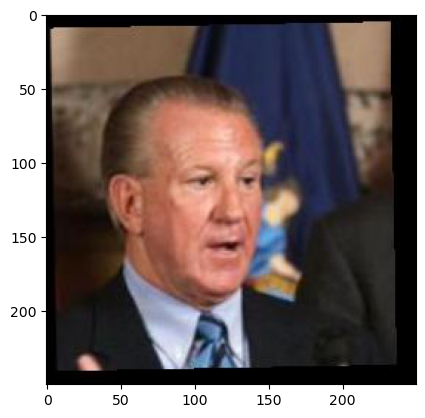

In [18]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

In [19]:
batch = next(iter(dataloader))
images = batch[0]  # Access the images from the batch
labels = batch[1]  # Access the labels from the batch

# Select a specific image from the batch
image_sample = images[30]
print(f"Sample image dimensions: {image_sample.shape}")


Sample image dimensions: torch.Size([3, 250, 250])


In [33]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        # Define the encoder layers
        self.enc_conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
        self.enc_bn1 = nn.BatchNorm2d(16)
        self.enc_conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.enc_bn2 = nn.BatchNorm2d(32)

        # Define the decoder layers with output shape [250, 250, 3]
        self.dec_conv1 = nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.dec_bn1 = nn.BatchNorm2d(16)
        self.dec_conv2 = nn.ConvTranspose2d(16, 3, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.dec_bn2 = nn.BatchNorm2d(3)

        # Upsampling layer to achieve the desired output size
        self.upsample = nn.Upsample(size=(250, 250), mode='bilinear', align_corners=True)

    def encoder(self, x):
        x = nn.functional.relu(self.enc_bn1(self.enc_conv1(x)))
        x = nn.functional.relu(self.enc_bn2(self.enc_conv2(x)))
        return x

    def decoder(self, x):
        x = nn.functional.relu(self.dec_bn1(self.dec_conv1(x)))
        x = torch.sigmoid(self.dec_bn2(self.dec_conv2(x)))
        x = self.upsample(x)
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [34]:
autoencoder = AE()

# Create a dummy input image (example size: 1x3x256x256, batch_size x channels x height x width)
# Replace this with your actual image tensor
input_image = torch.randn(1, 3, 256, 256)

# Forward the input image through the autoencoder
with torch.no_grad():
    encoded_output = autoencoder.encoder(input_image)
    decoded_output = autoencoder.decoder(encoded_output)

    # Print the shapes
    print(f"Shape of the encoder output: {encoded_output.shape}")
    print(f"Shape of the decoder output: {decoded_output.shape}")

# Ensure the model is in evaluation mode
autoencoder.eval()

# Perform a forward pass through the complete model to check the overall functionality
with torch.no_grad():
    output = autoencoder(input_image)
    print(f"Shape of the final output: {output.shape}")

Shape of the encoder output: torch.Size([1, 32, 64, 64])
Shape of the decoder output: torch.Size([1, 3, 250, 250])
Shape of the final output: torch.Size([1, 3, 250, 250])


In [38]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = AE()  # Create an instance of your autoencoder model
total_params = count_parameters(model)
print(f"Total number of trainable parameters in the model: {total_params}")

Total number of trainable parameters in the model: 19241


In [41]:
learning_rate = 0.001
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [37]:
loss_function=nn.MSELoss();